In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

Do not crop to avoid losing edge info. but have size tolerance for pre-procssing.

In [4]:
import os, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

# ============================================================
#  Basic helpers
# ============================================================

# side indices: 0=top, 1=right, 2=bottom, 3=left
OPP = {0: 2, 1: 3, 2: 0, 3: 1}

def rot90n(img, n):
    n %= 4
    if n == 0: return img
    if n == 1: return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if n == 2: return cv2.rotate(img, cv2.ROTATE_180)
    return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

# ---------- RGB (.rgb) reader with auto layout detection ----------

def read_rgb_raw_auto(path):
    size   = os.path.getsize(path)
    pixels = size // 3
    side   = int(round(pixels ** 0.5))

    with open(path, "rb") as f:
        raw = np.frombuffer(f.read(), dtype=np.uint8)

    # candidate 1: interleaved H×W×3
    inter = raw.reshape((side, side, 3))
    inter_bgr = cv2.cvtColor(inter, cv2.COLOR_RGB2BGR)

    # candidate 2: planar 3×H×W
    planar = raw.reshape((3, side, side)).transpose(1, 2, 0)
    planar_bgr = cv2.cvtColor(planar, cv2.COLOR_RGB2BGR)

    def colorfulness(bgr):
        b, g, r = cv2.split(bgr.astype(np.float32))
        return float(np.mean(np.std(np.stack([b, g, r], axis=-1), axis=-1)))

    return planar_bgr if colorfulness(planar_bgr) > colorfulness(inter_bgr) else inter_bgr

def read_image_auto(path):
    ext = os.path.splitext(path.lower())[1]
    if ext == ".rgb":
        return read_rgb_raw_auto(path)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(path)
    return img

# ============================================================
#  Segmentation + deskew with masks (aliasing-safe)
# ============================================================

def segment_pieces(bgr, thresh=None, min_area=300):
    """
    Segment rectangular pieces against dark background.

    If thresh is None, choose it adaptively from darkest 5% of pixels.
    """
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if thresh is None:
        flat = gray.reshape(-1)
        p5   = np.percentile(flat, 5)
        thr  = p5 + 3
        thr  = max(1, min(50, thr))
    else:
        thr = thresh

    mask = (gray > thr).astype(np.uint8)

    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8)

    pieces = []
    for i in range(1, num):
        x, y, w, h, area = stats[i]
        if area < min_area:
            continue
        crop  = bgr[y:y+h, x:x+w]
        cmask = (labels[y:y+h, x:x+w] == i).astype(np.uint8)
        pieces.append({"crop": crop, "mask": cmask})
    return pieces

def deskew_piece_masked(piece):
    """
    piece: {"crop": bgr, "mask": uint8}
    Returns upright_img, upright_mask (tightly cropped).
    """
    crop = piece["crop"]
    mask = piece["mask"]

    ys, xs = np.where(mask > 0)
    pts = np.vstack([xs, ys]).T.astype(np.float32)
    rect = cv2.minAreaRect(pts)
    angle, (w, h) = rect[2], rect[1]

    # force more "upright" orientation
    #if w < h:
    #    angle += 90.0

    center = (crop.shape[1] // 2, crop.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rot  = cv2.warpAffine(crop, M, (crop.shape[1], crop.shape[0]),
                          flags=cv2.INTER_LINEAR,
                          borderValue=(0,0,0))
    rmask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]),
                           flags=cv2.INTER_NEAREST,
                           borderValue=0)

    ys, xs = np.where(rmask > 0)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1

    #return rot[y0:y1, x0:x1], rmask[y0:y1, x0:x1]
    return crop, mask

# ============================================================
#  Edge signatures (mask-aware)
# ============================================================

def edge_signature_masked(bgr, mask, side, strip=3, N=128):
    """
    Build a 1D color+gradient signature along a side, using only mask==1 pixels
    to avoid aliasing/background.
    side: 0=top,1=right,2=bottom,3=left
    """
    h, w, _ = bgr.shape
    strip2 = min(strip*2, h if side in (0,2) else w)

    line_cols = []

    if side == 0:       # top
        for x in range(w):
            band_m = mask[0:strip2, x]
            band_c = bgr[0:strip2, x]
            if np.any(band_m):
                pix = band_c[band_m.astype(bool)]
            else:
                pix = band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))
    elif side == 2:     # bottom
        for x in range(w):
            band_m = mask[h-strip2:h, x]
            band_c = bgr[h-strip2:h, x]
            if np.any(band_m):
                pix = band_c[band_m.astype(bool)]
            else:
                pix = band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))
    elif side == 1:     # right
        for y in range(h):
            band_m = mask[y, w-strip2:w]
            band_c = bgr[y, w-strip2:w]
            if np.any(band_m):
                pix = band_c[band_m.astype(bool)]
            else:
                pix = band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))
    else:               # left
        for y in range(h):
            band_m = mask[y, 0:strip2]
            band_c = bgr[y, 0:strip2]
            if np.any(band_m):
                pix = band_c[band_m.astype(bool)]
            else:
                pix = band_c.reshape(-1,3)
            line_cols.append(pix.mean(axis=0))

    line = np.asarray(line_cols, dtype=np.uint8)   # (L,3)

    # convert to Lab for better perceptual distance
    lab = cv2.cvtColor(line.reshape(-1,1,3), cv2.COLOR_BGR2LAB).reshape(-1,3).astype(np.float32)

    src = np.linspace(0, len(lab)-1, len(lab), dtype=np.float32)
    dst = np.linspace(0, len(lab)-1, N,          dtype=np.float32)
    res = np.vstack([np.interp(dst, src, lab[:,c]) for c in range(3)]).T  # (N,3)

    grad = np.gradient(res, axis=0)
    sig  = np.hstack([res, grad])   # (N,6)
    return sig

# ============================================================
#  Load puzzle pieces + rotations + signatures (MASK VERSION)
# ============================================================

def load_puzzle_pieces_masked(path, Nsig=128):
    print("Reading input...")
    bgr = read_image_auto(path)

    print("Segmenting pieces...")
    comps = segment_pieces(bgr)
    print(f"Found {len(comps)} pieces.")

    print("Deskewing pieces (with masks)...")
    uprights, masks = [], []
    for p in comps:
        img_u, mask_u = deskew_piece_masked(p)
        uprights.append(img_u)
        masks.append(mask_u)

    print("Building rotations + mask-aware signatures...")
    rotations        = []
    rotations_masks  = []
    sigs             = {}

    for i, (img_u, mask_u) in enumerate(zip(uprights, masks)):
        rots = []
        rmsk = []
        for r in range(4):
            rots.append(rot90n(img_u, r))
            rmsk.append(rot90n(mask_u, r))
        rotations.append(rots)
        rotations_masks.append(rmsk)

        for r in range(4):
            img_r = rots[r]
            msk_r = rmsk[r]
            for s in range(4):
                sigs[(i,r,s)] = edge_signature_masked(img_r, msk_r, s, strip=3, N=Nsig)
        
    print("Done preprocessing (aliasing-safe).")
    return uprights, masks, rotations, rotations_masks, sigs

# ============================================================
#  Border detection (rotation-invariant)
# ============================================================

def infer_grid_dims(N):
    best = None
    for r in range(1, int(math.sqrt(N))+1):
        if N % r == 0:
            c = N // r
            if best is None or abs(r-c) < abs(best[0]-best[1]):
                best = (r,c)
    return best

def edge_distance(sigA, sigB):
    return float(np.linalg.norm(sigA - sigB[::-1]))

def compute_outerness(rotations, sigs):
    keys = list(sigs.keys())  # (i,r,s)
    outer = {}
    vals  = []
    for (i,ri,si) in keys:
        A = sigs[(i,ri,si)]
        best = np.inf
        for (j,rj,sj) in keys:
            if i == j: 
                continue
            if sj != OPP[si]:
                continue
            d = float(np.linalg.norm(A - sigs[(j,rj,sj)][::-1]))
            if d < best:
                best = d
        outer[(i,ri,si)] = best
        vals.append(best)

    vals = np.array(vals, dtype=np.float32)
    med  = np.median(vals)
    mad  = np.median(np.abs(vals - med)) + 1e-8
    thr  = med + 2.5 * mad

    border_mask = {k: (outer[k] > thr) for k in outer}
    return outer, border_mask, thr

def classify_pieces(rotations, border_mask):
    N = len(rotations)
    border_sides = {}
    roles = {}
    for i in range(N):
        votes = {c:0 for c in range(4)}
        for r in range(4):
            for s in range(4):
                if border_mask[(i,r,s)]:
                    c = (s - r) % 4
                    votes[c] += 1
        canonical_is_border = {c:(votes[c]>0) for c in range(4)}

        for r in range(4):
            sides_r = set()
            for s in range(4):
                c = (s - r) % 4
                if canonical_is_border[c]:
                    sides_r.add(s)
            border_sides[(i,r)] = sides_r

        n_border = sum(1 for c in range(4) if canonical_is_border[c])
        if n_border >= 2:
            roles[i] = "corner"
        elif n_border == 1:
            roles[i] = "edge"
        else:
            roles[i] = "interior"
    return roles, border_sides

def outward_sides_for_cell(r, c, R, C):
    sides = set()
    if r == 0:   sides.add(0)
    if c == C-1: sides.add(1)
    if r == R-1: sides.add(2)
    if c == 0:   sides.add(3)
    return sides

def rotation_ok_for_cell(i, rot, r, c, R, C, border_sides):
    outward = outward_sides_for_cell(r, c, R, C)
    sides   = border_sides[(i, rot)]
    for s in outward:
        if s not in sides:
            return False
    return True

def inward_border_penalty(i, rot, r, c, R, C, border_sides, gamma=30.0):
    outward = outward_sides_for_cell(r, c, R, C)
    sides   = border_sides[(i, rot)]
    inward  = {0,1,2,3} - outward
    n_bad   = sum(1 for s in inward if s in sides)
    return gamma * n_bad

# ============================================================
#  Best pair orientation + MST
# ============================================================

def best_pair_between(i, j, sigs):
    best = (1e18, 0,0,0,0)
    for ri in range(4):
        for si in range(4):
            sj = OPP[si]
            A  = sigs[(i,ri,si)]
            for rj in range(4):
                d = edge_distance(A, sigs[(j,rj,sj)])
                if d < best[0]:
                    best = (d, ri, si, rj, sj)
    return best

def kruskal_mst(N, edges):
    parent = list(range(N))
    rank   = [0]*N

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a,b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return False
        if rank[ra] < rank[rb]:
            parent[ra] = rb
        elif rank[ra] > rank[rb]:
            parent[rb] = ra
        else:
            parent[rb] = ra
            rank[ra]  += 1
        return True

    mst = []
    for w,i,j in sorted(edges, key=lambda e:e[0]):
        if union(i,j):
            mst.append((w,i,j))
            if len(mst) == N-1:
                break
    return mst

# ============================================================
#  Seam cost + total cost + uniform rendering
# ============================================================

def seam_cost_between_cells(grid, rotations, sigs, r1, c1, r2, c2):
    (i1, rot1) = grid[r1][c1]
    (i2, rot2) = grid[r2][c2]

    if r1 == r2:
        if c2 == c1+1:
            s1, s2 = 1, 3
        else:
            s1, s2 = 3, 1
    elif c1 == c2:
        if r2 == r1+1:
            s1, s2 = 2, 0
        else:
            s1, s2 = 0, 2
    else:
        return 0.0

    sig1 = sigs[(i1, rot1, s1)]
    sig2 = sigs[(i2, rot2, s2)]
    return float(np.linalg.norm(sig1 - sig2[::-1]))

def total_grid_seam_cost(grid, rotations, sigs):
    R, C = len(grid), len(grid[0])
    total = 0.0
    for r in range(R):
        for c in range(C-1):
            total += seam_cost_between_cells(grid, rotations, sigs, r, c, r, c+1)
    for r in range(R-1):
        for c in range(C):
            total += seam_cost_between_cells(grid, rotations, sigs, r, c, r+1, c)
    return total

def render_grid_uniform(grid, rotations, out_path=None, show=True, title=""):
    R, C = len(grid), len(grid[0])

    hs, ws = [], []
    for r in range(R):
        for c in range(C):
            i, rot_idx = grid[r][c]
            h, w = rotations[i][rot_idx].shape[:2]
            hs.append(h); ws.append(w)
    H0 = int(np.median(hs))
    W0 = int(np.median(ws))

    canvas = np.zeros((R*H0, C*W0, 3), np.uint8)
    for rr in range(R):
        for cc in range(C):
            i, rot_idx = grid[rr][cc]
            img = rotations[i][rot_idx]
            patch = cv2.resize(img, (W0, H0), interpolation=cv2.INTER_CUBIC)
            y0 = rr * H0
            x0 = cc * W0
            canvas[y0:y0+H0, x0:x0+W0] = patch

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, canvas)
    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()
    return canvas

def render_solution(solution, out_path=None, show=True, title=""):
    """Render solution from solve() which returns [[piece, [row, col]], ...]"""
    
    pieces = []
    positions = []
    for item in solution:
        pieces.append(item[0])
        # Ensure position is a list of 2 ints
        pos = item[1]
        if isinstance(pos, np.ndarray):
            pos = pos.tolist()
        positions.append([int(pos[0]), int(pos[1])])
    
    positions = np.array(positions)
    
    # Find grid bounds
    min_row = positions[:, 0].min()
    max_row = positions[:, 0].max()
    min_col = positions[:, 1].min()
    max_col = positions[:, 1].max()
    
    R = max_row - min_row + 1
    C = max_col - min_col + 1
    
    # Calculate uniform cell size
    hs = [p.shape[0] for p in pieces]
    ws = [p.shape[1] for p in pieces]
    H0 = int(np.median(hs))
    W0 = int(np.median(ws))
    
    # Create canvas
    canvas = np.zeros((R*H0, C*W0, 3), np.uint8)
    
    # Place pieces
    for piece, pos in zip(pieces, positions):
        row = pos[0] - min_row
        col = pos[1] - min_col
        
        patch = cv2.resize(piece, (W0, H0), interpolation=cv2.INTER_CUBIC)
        y0 = row * H0
        x0 = col * W0
        canvas[y0:y0+H0, x0:x0+W0] = patch
    
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, canvas)
    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(title)
        plt.show()
    
    return canvas

# ============================================================
#  Rectangular MST assembly (tolerant size penalty)
# ============================================================

def assemble_rectangular_multi_seed(
        rotations, sigs, roles, border_sides,
        best_pairs, mst_adj,
        lam_mst=80.0, gamma=30.0,
        lam_size_h=40.0, lam_size_w=40.0,
        tol_h=2, tol_w=2):
    """
    N pieces -> rectangular grid R×C (R*C=N, as square-ish as possible).

    Size penalty is used only when size differences exceed (tol_h, tol_w):
      - small differences (e.g. 100 vs 101) are ignored,
      - big differences (e.g. 80 vs 120) are penalized to enforce
        real rectangle consistency.
    """
    N = len(rotations)
    R, C = infer_grid_dims(N)
    print(f"Using grid {R} x {C} for N={N}")

    def make_local_cell_cost(row_target_h, col_target_w):
        def local_cell_cost(grid, i, rot, rr, cc):
            cost  = 0.0
            bonus = 0.0

            # ----- seam with top neighbor -----
            if rr > 0 and grid[rr-1][cc] is not None:
                j, rj = grid[rr-1][cc]
                sig1 = sigs[(j, rj, 2)]
                sig2 = sigs[(i, rot, 0)]
                d    = float(np.linalg.norm(sig1 - sig2[::-1]))
                cost += d

                if j in mst_adj[i]:
                    bonus += 10.0

                bp = best_pairs.get((j,i), None)
                if bp is not None:
                    ri_best, si_best, rj_best, sj_best, d_best = bp
                    if (rj,2,rot,0) == (ri_best, si_best, rj_best, sj_best):
                        bonus += lam_mst

            # ----- seam with left neighbor -----
            if cc > 0 and grid[rr][cc-1] is not None:
                j, rj = grid[rr][cc-1]
                sig1 = sigs[(j, rj, 1)]
                sig2 = sigs[(i, rot, 3)]
                d    = float(np.linalg.norm(sig1 - sig2[::-1]))
                cost += d

                if j in mst_adj[i]:
                    bonus += 10.0

                bp = best_pairs.get((j,i), None)
                if bp is not None:
                    ri_best, si_best, rj_best, sj_best, d_best = bp
                    if (rj,1,rot,3) == (ri_best, si_best, rj_best, sj_best):
                        bonus += lam_mst

            # ----- inward border penalty -----
            cost += inward_border_penalty(i, rot, rr, cc, R, C, border_sides,
                                          gamma=gamma)

            # ----- tolerant size penalties -----
            h, w = rotations[i][rot].shape[:2]

            if row_target_h[rr] is not None:
                dh = abs(h - row_target_h[rr])
                if dh > tol_h:
                    cost += lam_size_h * (dh - tol_h)

            if col_target_w[cc] is not None:
                dw = abs(w - col_target_w[cc])
                if dw > tol_w:
                    cost += lam_size_w * (dw - tol_w)

            return cost - bonus
        return local_cell_cost

    # ----- candidate seeds for top-left -----
    seeds = []
    for i in range(N):
        for r in range(4):
            if rotation_ok_for_cell(i, r, 0, 0, R, C, border_sides):
                seeds.append((i,r))
    if not seeds:
        seeds = [(i,r) for i in range(N) for r in range(4)]
    print(f"Trying {len(seeds)} seeds for top-left")

    best_grid = None
    best_cost = float("inf")
    best_seed = None

    # ----- try each seed -----
    for seed in seeds:
        (i0, r0) = seed
        grid = [[None]*C for _ in range(R)]
        used = set([i0])
        grid[0][0] = (i0, r0)

        row_target_h = [None]*R
        col_target_w = [None]*C
        h0, w0 = rotations[i0][r0].shape[:2]
        row_target_h[0] = h0
        col_target_w[0] = w0

        local_cell_cost = make_local_cell_cost(row_target_h, col_target_w)

        for rr in range(R):
            for cc in range(C):
                if rr == 0 and cc == 0:
                    continue

                best = (1e18, None)

                # 1st pass: respect border classification
                for i in range(N):
                    if i in used:
                        continue
                    for rot in range(4):
                        if not rotation_ok_for_cell(i, rot, rr, cc, R, C, border_sides):
                            continue
                        v = local_cell_cost(grid, i, rot, rr, cc)
                        if v < best[0]:
                            best = (v, (i,rot))

                # fallback: ignore border if nothing fits
                if best[1] is None:
                    for i in range(N):
                        if i in used:
                            continue
                        for rot in range(4):
                            v = local_cell_cost(grid, i, rot, rr, cc)
                            if v < best[0]:
                                best = (v, (i,rot))

                i_best, rot_best = best[1]
                grid[rr][cc] = (i_best, rot_best)
                used.add(i_best)

                h, w = rotations[i_best][rot_best].shape[:2]
                if row_target_h[rr] is None:
                    row_target_h[rr] = h
                if col_target_w[cc] is None:
                    col_target_w[cc] = w

        cost = total_grid_seam_cost(grid, rotations, sigs)
        if cost < best_cost:
            best_cost = cost
            best_grid = grid
            best_seed = seed

    print("Best seed:", best_seed, "with seam cost:", best_cost)
    return best_grid



def get_image_bounds(pieces):
    total_width = 0
    total_height = 0
    total_volume = 0
    for p in pieces:
        total_width += p.shape[1]
        total_height += p.shape[0]
        total_volume += p.shape[1]*p.shape[0]
    side_length = math.sqrt(total_volume)
    return round(total_height/side_length), round(total_width/side_length), round(side_length)
    

def solve(pieces: list):
    total_difference = float('inf')
    ordered_pieces = []

    heightp, widthp, side_len = get_image_bounds(pieces)
    print(heightp, widthp, side_len)
    
    for i in range(len(pieces)):
        print("starting iteration: " + str(i))
        pcopy = pieces.copy()
        currp = pcopy[i]
        pcopy.pop(i)
        pos = [0,0]
        #grid = np.full((side_len+5, side_len+5), -1)
        grid = np.full((widthp, heightp), -1)
        temporder = [[currp, pos]]
        direction = "r"
        oppdir = "l"
        #pos = update_pos(pos, direction, currp)
        pos = [0, 1]
        grid[0][0] = 1
        result = recursive_solver(currp, pcopy, temporder, direction, oppdir, pos, grid)

        if result[0] < total_difference:
            total_difference = result[0]
            ordered_pieces = result[1]
        

    return ordered_pieces


def recursive_solver(currp, pcopy, temporder, direction, oppdir, pos, grid):

    #base case
    if len(pcopy) <= 1:
        edge = return_edge(currp, direction)
        edge2 = return_edge(pcopy[0], oppdir)
        neworder = temporder + [[pcopy[0], pos]]
        return [get_squared_difference(edge, edge2, oppdir), neworder]

    
    edge = return_edge(currp, direction)
    matches = find_matching_edge(edge, pcopy, oppdir)

    best_diff = float('inf')
    sol = None
    
    for i in range(min(1, len(pcopy))):
        neworder = temporder + [[matches[i][1], pos]]
        c = pcopy.copy()
        c.pop(matches[i][2])
        g = grid.copy()
        g[pos[0]][pos[1]] = 1
        if direction == 'r' and (pos[1]+1 >= g.shape[1] or g[pos[0]][pos[1]+1] == 1):
            direction = 'b'
            oppdir = 't'
        elif direction == 'b' and (pos[0]+1 >= g.shape[0] or g[pos[0]+1][pos[1]] == 1):
            direction = 'l'
            oppdir = 'r'
        elif direction == 'l' and (pos[1]-1 < 0 or g[pos[0]][pos[1]-1] == 1):
            direction = 't'
            oppdir = 'b'
        elif direction == 't' and g[pos[0]-1][pos[1]] == 1:
            direction = 'r'
            oppdir = 'l'
        pos = update_pos_squares(pos, direction)
        try:
            g[pos[0]][pos[1]] = 1
        except IndexError:
            print(pos)
            print(g)
            print(direction)
            print(oppdir)
            print(g.shape)

        
        solve = recursive_solver(matches[i][1], c, neworder, direction, oppdir, pos, g)
        if solve[0] < best_diff:
            best_diff = solve[0] + matches[i][0]
            sol = solve[1]
    
    return [best_diff, sol]

def return_edge(piece, edge):
    if edge == "t":
        return piece[0, :, :]
    elif edge == "b":
        return piece[-1, :, :]
    elif edge == "r":
        return piece[:, -1, :]
    elif edge == "l":
        return piece[:, 0, :]
    return None

def update_pos(pos, direction, currp):
    if direction == "t":
        return [pos[0]-currp.shape[0], pos[1]]
    elif direction == "b":
        return [pos[0]+currp.shape[0], pos[1]]
    elif direction == "r":
        return [pos[0], pos[1]+currp.shape[1]]
    elif direction == "l":
        return [pos[0], pos[1]-currp.shape[1]]
    return None

def update_pos_squares(pos, direction):
    if direction == "t":
        return [pos[0]-1, pos[1]]
    elif direction == "b":
        return [pos[0]+1, pos[1]]
    elif direction == "r":
        return [pos[0], pos[1]+1]
    elif direction == "l":
        return [pos[0], pos[1]-1]
    return None
    

def find_matching_edge(edge, pieces, direction):

    edge_list = []
    
    for p in range(len(pieces)):
        matching_edge = return_edge(pieces[p], direction)
        diff = get_squared_difference(edge, matching_edge, direction)
        edge_list.append([diff, pieces[p], p])

    edge_list.sort()
    return edge_list

def get_squared_difference(edge1, edge2, d):
    total_dif = 0
    for i in range(min(len(edge1), len(edge2))):
        for j in range(3):
            total_dif += math.pow((int(edge1[i][j])-int(edge2[i][j])), 2)

    return total_dif


# ============================================================
#  Top-level solver
# ============================================================

def solve_puzzle_mst_rectangular(path, out_dir="./outputs_mst_rect", show=True):
    print(f"=== Solving: {path} ===")
    uprights, masks, rotations, rotations_masks, sigs = \
        load_puzzle_pieces_masked(path)
    N = len(rotations)
    print(f"{os.path.basename(path)}: {N} pieces")


    grid = solve(uprights)

    for p in range(len(grid)):
        print("piece "+ str(p) + " : " + str(grid[p][1]))
    
    """
    outer, border_mask, thr = compute_outerness(rotations, sigs)
    roles, border_sides     = classify_pieces(rotations, border_mask)
    print("Border threshold:", thr)

    # piece-level edges for MST + best oriented contact between each pair
    edges      = []
    best_pairs = {}
    for i in range(N):
        for j in range(i+1, N):
            d,ri,si,rj,sj = best_pair_between(i, j, sigs)
            edges.append((d, i, j))
            best_pairs[(i,j)] = (ri,si,rj,sj,d)
            best_pairs[(j,i)] = (rj,sj,ri,si,d)

    mst = kruskal_mst(N, edges)
    mst_adj = defaultdict(set)
    for w,i,j in mst:
        mst_adj[i].add(j)
        mst_adj[j].add(i)

    grid = assemble_rectangular_multi_seed(
        rotations, sigs, roles, border_sides,
        best_pairs, mst_adj,
        lam_mst=80.0, gamma=30.0,
        lam_size_h=40.0, lam_size_w=40.0,
        tol_h=2, tol_w=2
    )

    base = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(out_dir, f"{base}_mst_rect.png")
    canvas = render_grid_uniform(
        grid, rotations,
        out_path=out_path, show=show,
        title=f"MST rect: {base}"
    )
    print("Saved ->", out_path)
    return canvas"""

    base = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(out_dir, f"{base}_mst_rect.png")
    canvas = render_solution(
        grid,
        out_path=out_path, show=show,
        title=f"MST rect: {base}"
    )
    print("Saved ->", out_path)
    return canvas


In [5]:
def show_upright_pieces(uprights, max_cols=4, title="Upright pieces"):
    N = len(uprights)
    cols = min(max_cols, N)
    rows = int(np.ceil(N / cols))

    plt.figure(figsize=(3*cols, 3*rows))
    for i, piece in enumerate(uprights):
        plt.subplot(rows, cols, i+1)
        plt.imshow(cv2.cvtColor(piece, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{i}", fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

=== Solving: sample3_translate.rgb ===
Reading input...
Segmenting pieces...
Found 20 pieces.
Deskewing pieces (with masks)...
Building rotations + mask-aware signatures...
Done preprocessing (aliasing-safe).
sample3_translate.rgb: 20 pieces
5 4 400
starting iteration: 0
starting iteration: 1
starting iteration: 2
starting iteration: 3
starting iteration: 4
starting iteration: 5
starting iteration: 6
starting iteration: 7
starting iteration: 8
starting iteration: 9
starting iteration: 10
starting iteration: 11
starting iteration: 12
starting iteration: 13
starting iteration: 14
starting iteration: 15
starting iteration: 16
starting iteration: 17
starting iteration: 18
starting iteration: 19
piece 0 : [0, 0]
piece 1 : [0, 1]
piece 2 : [0, 2]
piece 3 : [0, 3]
piece 4 : [0, 4]
piece 5 : [1, 4]
piece 6 : [2, 4]
piece 7 : [3, 4]
piece 8 : [3, 3]
piece 9 : [3, 2]
piece 10 : [3, 1]
piece 11 : [3, 0]
piece 12 : [2, 0]
piece 13 : [1, 0]
piece 14 : [1, 1]
piece 15 : [1, 2]
piece 16 : [1, 3]
piec

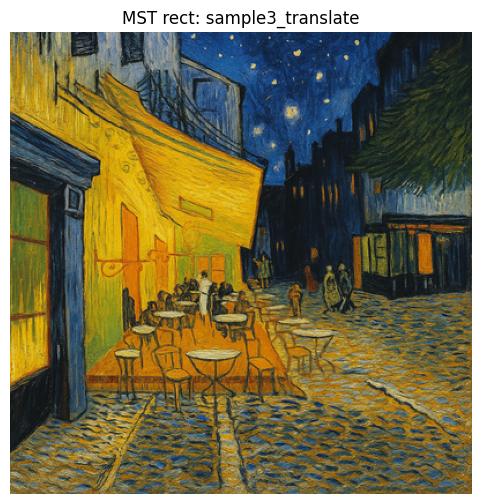

Saved -> ./outputs_mst_rect\sample3_translate_mst_rect.png


array([[[ 49, 113, 128],
        [ 62, 117, 131],
        [ 68, 100, 100],
        ...,
        [ 43,  34,  23],
        [ 28,  25,  18],
        [ 31,  27,  20]],

       [[ 56, 117, 129],
        [ 78, 144, 158],
        [ 71, 103,  99],
        ...,
        [ 49,  40,  28],
        [ 32,  27,  19],
        [ 28,  26,  19]],

       [[ 56, 112, 122],
        [ 70, 122, 129],
        [ 65,  97,  95],
        ...,
        [ 41,  33,  21],
        [ 32,  28,  19],
        [ 29,  26,  19]],

       ...,

       [[ 71, 143, 173],
        [ 42, 100, 130],
        [ 58, 119, 148],
        ...,
        [ 32,  95, 131],
        [ 33,  90, 124],
        [ 31,  88, 122]],

       [[ 72, 114, 127],
        [ 63, 106, 121],
        [ 60, 111, 134],
        ...,
        [ 39, 102, 137],
        [ 30, 103, 141],
        [ 23,  90, 126]],

       [[ 81, 117, 124],
        [ 91, 144, 154],
        [ 80, 123, 135],
        ...,
        [ 33,  91, 124],
        [ 30, 101, 144],
        [ 29, 103, 145]]

In [6]:
solve_puzzle_mst_rectangular("sample3_translate.rgb")